In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [0]:
keras.utils.get_file('/content/bsd_images.zip','http://bit.ly/35pHZlC',extract=True)
!unzip /content/bsd_images.zip

37527552/37520292 [==============================] - 0s 0us/step
Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: image

In [0]:
import pathlib

image_root=pathlib.Path('/content/images')
all_image_paths=list(image_root.glob('*/*'))

print(all_image_paths[:10])

[PosixPath('/content/images/test/80090.jpg'), PosixPath('/content/images/test/141012.jpg'), PosixPath('/content/images/test/163004.jpg'), PosixPath('/content/images/test/69007.jpg'), PosixPath('/content/images/test/285022.jpg'), PosixPath('/content/images/test/196062.jpg'), PosixPath('/content/images/test/257098.jpg'), PosixPath('/content/images/test/112090.jpg'), PosixPath('/content/images/test/16004.jpg'), PosixPath('/content/images/test/14092.jpg')]


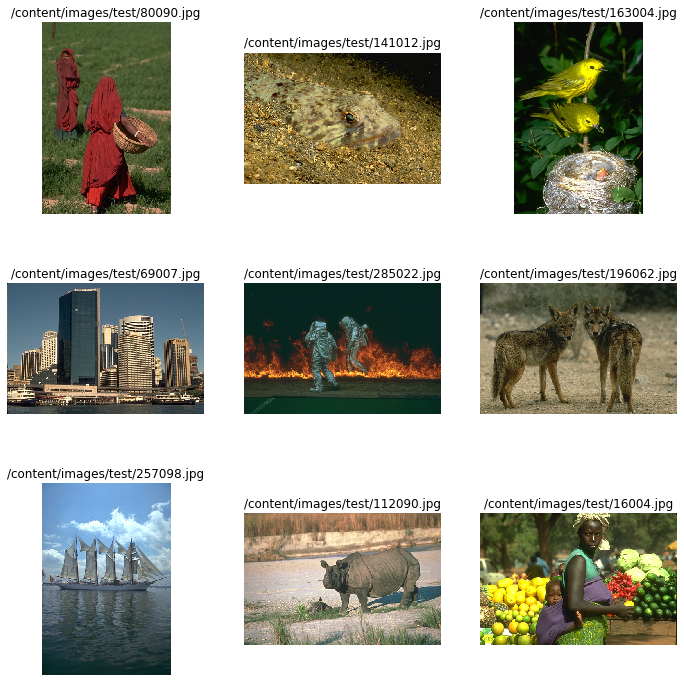

In [0]:
plt.figure(figsize=(12,12))

for c in range(9):
  plt.subplot(3,3,c+1)
  plt.imshow(plt.imread(all_image_paths[c]))
  plt.title(all_image_paths[c])
  plt.axis('off')

plt.show()

In [0]:
# 데이터셋별로 경로 저장 

train_path,validation_path,test_path=[],[],[]

for image_path in all_image_paths:
  if str(image_path).split('.')[-1]!='jpg':
    continue
  if str(image_path).split('/')[-2]=='train':
    train_path.append(str(image_path))
  elif str(image_path).split('/')[-2]=='test':
    test_path.append(str(image_path))
  else:
    validation_path.append(str(image_path))

In [0]:
# 저해상도, 고해상도 이미지 조각 만들기

def get_hr_and_lr(image_path): #high relolution, low resolution
  img=tf.io.read_file(image_path) #tensor
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)

  hr=tf.image.random_crop(img,[50,50,3])
  lr=tf.image.resize(hr,[25,25])
  lr=tf.image.resize(lr,[50,50])

  return lr,hr

In [0]:
get_hr_and_lr(train_path[0])

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


(<tf.Tensor 'resize_3/Squeeze:0' shape=(50, 50, 3) dtype=float32>,
 <tf.Tensor 'random_crop_1:0' shape=(50, 50, 3) dtype=float32>)

In [0]:
# 훈련, 검증 데이터셋 정의

train_dataset=tf.data.Dataset.list_files(train_path)
train_dataset=train_dataset.map(get_hr_and_lr) # DatasetV1Adapter
train_dataset=train_dataset.repeat()  # repeat(step_n) : 원하는 epoch 수를 넣을 수 있다. 아무런 파라미터를 주지 않는다면 iteration이 무제한으로 돌아간다.
train_dataset=train_dataset.batch(16)

valid_dataset=tf.data.Dataset.list_files(validation_path)
valid_dataset=valid_dataset.map(get_hr_and_lr)
valid_dataset=valid_dataset.repeat()
valid_dataset=valid_dataset.batch(1)

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


Rednet

In [0]:
def REDNet(num_layers):

  conv_layers=[]
  deconv_layers=[]
  residual_layers=[]

  # 입력 레이어 정의
  inputs=keras.layers.Input(shape=(None,None,3))

  conv_layers.append(keras.layers.Conv2D(filters=3,kernel_size=3,padding='same',activation='relu'))

  for i in range(num_layers-1):
    conv_layers.append(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
    deconv_layers.append(keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu'))
  deconv_layers.append(keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding='same'))

  x=conv_layers[0](inputs)

  # encoder
  for i in range(num_layers-1):
    x=conv_layers[i+1](x)
    if i%2==0:
      residual_layers.append(x) # 두번마다 output을 reidual_layers에 append

  # decoder
  for i in range(num_layers-1):
    if(i%2==1):
      x=keras.layers.Add()([x,residual_layers.pop()])
      x=keras.layers.Activation('relu')(x) # 두번마다 residual 값 더함
    x=deconv_layers[i](x)

  x=deconv_layers[-1](x)

  model=keras.Model(inputs=inputs,outputs=x)
  
  return model

In [0]:
def psnr_metric(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,max_val=1.0)

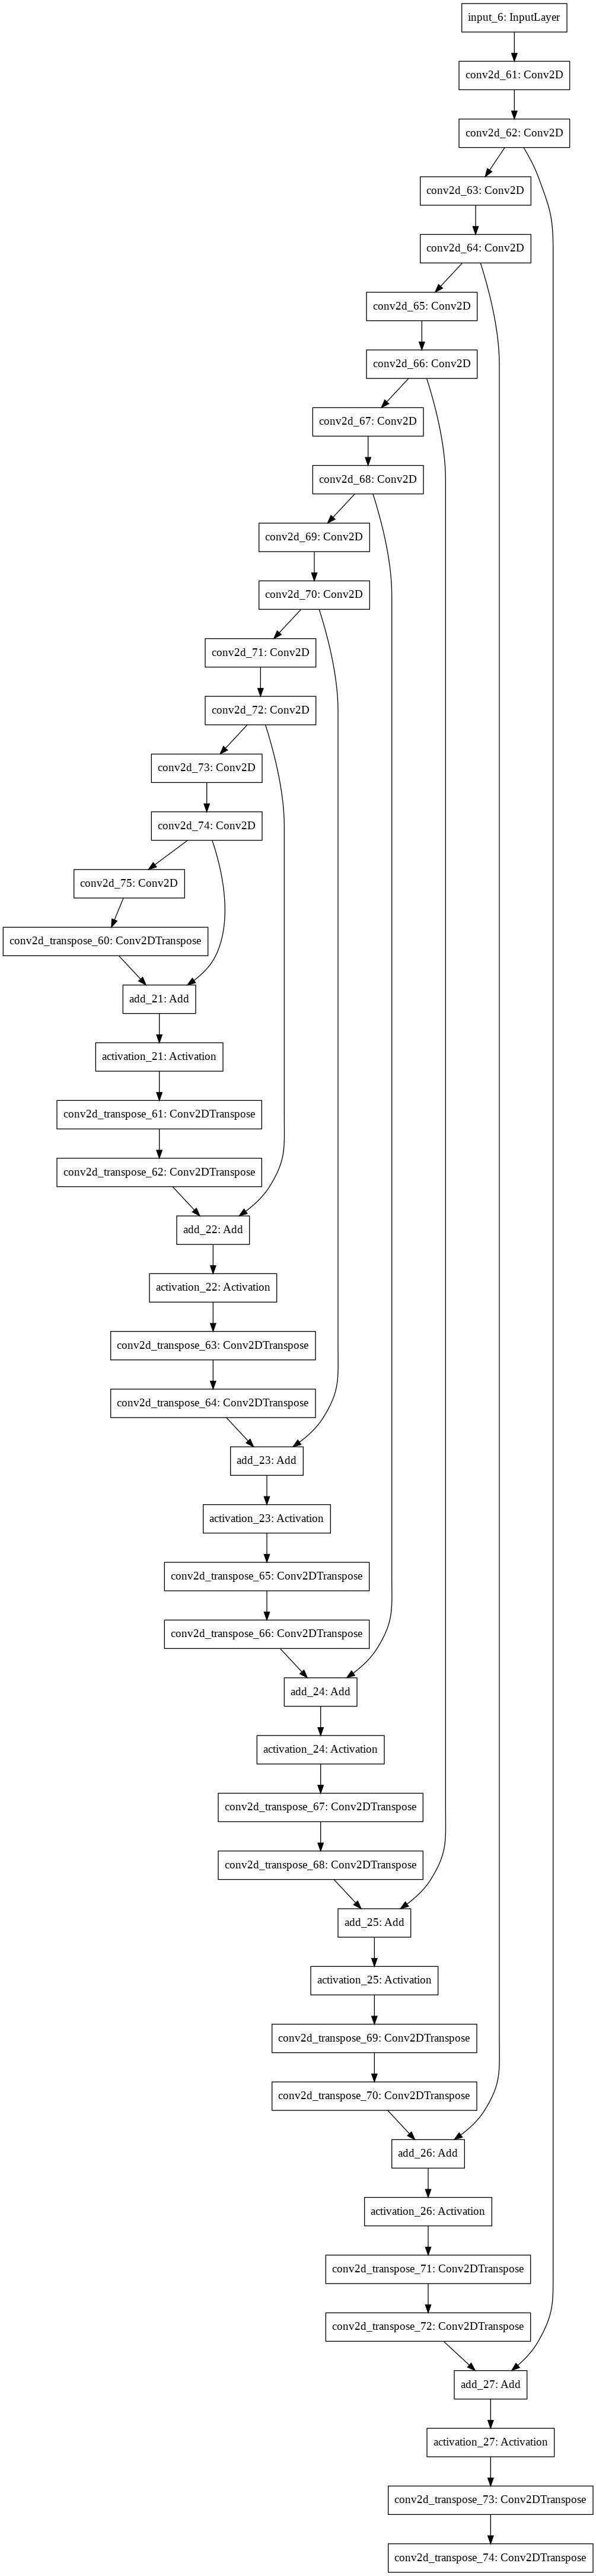

In [0]:
model=REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001),loss='mse',metrics=[psnr_metric])
keras.utils.plot_model(model) # 시각화

In [0]:
history=model.fit_generator(train_dataset,
                            epochs=1000,
                            steps_per_epoch=len(train_path)//16,
                            validation_data=valid_dataset,
                            validation_steps=len(validation_path),
                            verbose=2)

Train for 12 steps, validate for 100 steps
Epoch 1/1000
12/12 - 10s - loss: 0.1561 - psnr_metric: 9.9794 - val_loss: 0.0329 - val_psnr_metric: 16.2997
Epoch 2/1000
12/12 - 1s - loss: 0.0388 - psnr_metric: 15.0615 - val_loss: 0.0256 - val_psnr_metric: 16.9339
Epoch 3/1000
12/12 - 1s - loss: 0.0288 - psnr_metric: 16.3991 - val_loss: 0.0226 - val_psnr_metric: 17.2796
Epoch 4/1000
12/12 - 1s - loss: 0.0236 - psnr_metric: 17.2030 - val_loss: 0.0195 - val_psnr_metric: 17.8054
Epoch 5/1000
12/12 - 1s - loss: 0.0223 - psnr_metric: 17.5133 - val_loss: 0.0171 - val_psnr_metric: 18.7187
Epoch 6/1000
12/12 - 1s - loss: 0.0177 - psnr_metric: 18.7738 - val_loss: 0.0151 - val_psnr_metric: 19.5446
Epoch 7/1000
12/12 - 1s - loss: 0.0168 - psnr_metric: 19.0638 - val_loss: 0.0133 - val_psnr_metric: 20.2240
Epoch 8/1000
12/12 - 1s - loss: 0.0151 - psnr_metric: 19.4718 - val_loss: 0.0117 - val_psnr_metric: 20.7162
Epoch 9/1000
12/12 - 1s - loss: 0.0128 - psnr_metric: 20.5645 - val_loss: 0.0108 - val_psnr_m

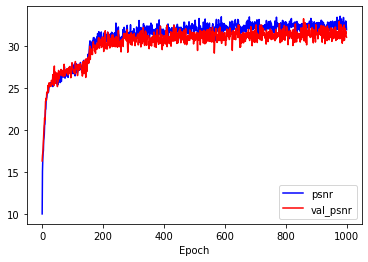

In [0]:

plt.plot(history.history['psnr_metric'],'b-',label='psnr')
plt.plot(history.history['val_psnr_metric'],'r-',label='val_psnr')
plt.xlabel('Epoch')

plt.legend()
plt.show()

In [0]:
img=tf.io.read_file(test_path[random.randint(0,len(test_path))]) #tensor
img=tf.image.decode_jpeg(img,channels=3); # Decode a JPEG-encoded image to a uint8 tensor.
hr=tf.image.convert_image_dtype(img,tf.float32) # Convert image to dtype, scaling its values if needed.

lr=tf.image.resize(hr,[hr.shape[0]//2,hr.shape[1]//2]) 
lr=tf.image.resize(lr,[hr.shape[0],hr.shape[1]])

predict_hr=model.predict(np.expand_dims(lr,axis=0))

print(tf.image.psnr(np.squeeze(predict_hr,axis=0),hr,max_val=1.0))
print(tf.image.psnr(lr,hr,max_val=1.0))

tf.Tensor(27.901947, shape=(), dtype=float32)
tf.Tensor(25.089153, shape=(), dtype=float32)


In [0]:
np.expand_dims(lr,axis=0).shape

(1, 481, 321, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


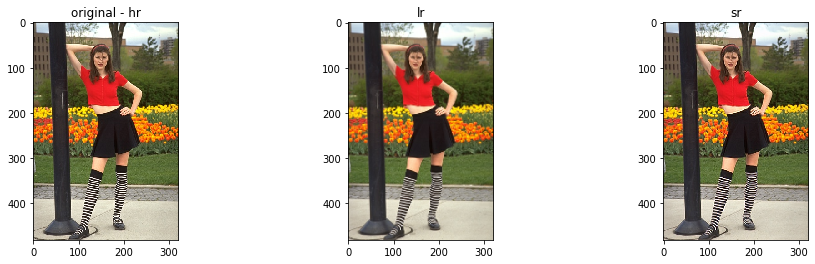

In [0]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr,axis=0))
plt.title('sr')

plt.show()

Set5

In [0]:
image_path=keras.utils.get_file('butterfly.png','https://storage.googleapis.com/kagglesdsdata/datasets/271102/562453/Set5/Set5/butterfly.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1584418140&Signature=hfoE7peQkZYzU7Xdy5aSmHf83LLz9va8oNirUodwSNp5fR2MWq9rFVRz8KkEvDA2XY%2Fjeof9Y0WVzkzqEZcFf1ir8wSiFi2Na7hizGkPwKnUqI6pznHc5Ij9bzlCgbN1wAvGH9GyCzUeP0PDY4w6jUJYJmkjmwAoAa%2Ba1bnsf%2FU0LDsN35C3DOdpt1V4fwrhQNVvCKll7zt2dbIfdg7Rd8kWiM1MgR4kg4x2wDagBKatzfXImU4CeqkTzkY5b08hOZmKVwsR%2FUS0k6Q7BInv4spRDjrMDPhty%2F2ScDa7Ff90pQADOGwctHjpStZjVRlDITneZmWFss2zR6KHJqHXHg%3D%3D')
img=tf.io.read_file(image_path)
img=tf.image.decode_jpeg(img,channels=3)

hr=tf.image.convert_image_dtype(img,tf.float32)
lr=tf.image.resize(hr,[hr.shape[0]//2,hr.shape[1]//2])
lr=tf.image.resize(lr,[hr.shape[0],hr.shape[1]])

print(type(hr))
print(type(lr))

predict_hr=model.predict(np.expand_dims(lr,axis=0))

print(tf.image.psnr(np.squeeze(predict_hr,axis=0),hr,max_val=1.0))
print(tf.image.psnr(lr,hr,max_val=1.0))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(30.410156, shape=(), dtype=float32)
tf.Tensor(24.783773, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


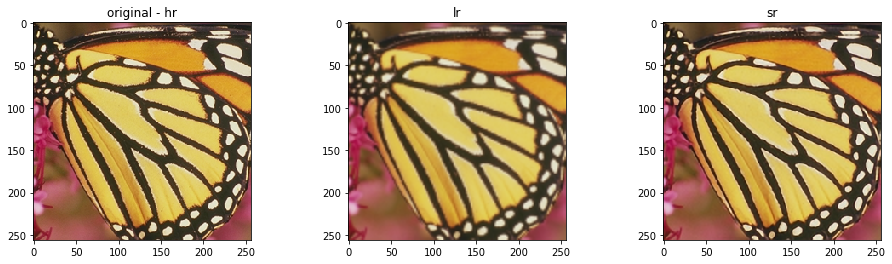

In [0]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr,axis=0))
plt.title('sr')

plt.show()

1/4로 축소

In [0]:
# 저해상도, 고해상도 이미지 조각 만들기

def get_hr_and_lr_flip_s4(image_path): #high relolution, low resolution
  img=tf.io.read_file(image_path)
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)

  hr=tf.image.random_crop(img,[50,50,3])
  lr=tf.image.resize(hr,[12,12])
  lr=tf.image.resize(lr,[50,50])

  if random.random()<0.25:
    hr=tf.image.flip_left_right(hr)
    lr=tf.image.flip_left_right(lr)

  if random.random()<0.25:
    hr=tf.image.flip_up_down(hr)
    lr=tf.image.flip_up_down(lr)

  return lr,hr

In [0]:
# 훈련, 검증 데이터셋 정의

train_dataset=tf.data.Dataset.list_files(train_path)
train_dataset=train_dataset.map(get_hr_and_lr_flip_s4)
train_dataset=train_dataset.repeat()  # repeat(step_n) : 원하는 epoch 수를 넣을 수 있다. 아무런 파라미터를 주지 않는다면 iteration이 무제한으로 돌아간다.
train_dataset=train_dataset.batch(16)

valid_dataset=tf.data.Dataset.list_files(validation_path)
valid_dataset=valid_dataset.map(get_hr_and_lr_flip_s4)
valid_dataset=valid_dataset.repeat()
valid_dataset=valid_dataset.batch(1)

In [0]:
history=model.fit_generator(train_dataset,epochs=1000,steps_per_epoch=len(train_path)//16,validation_data=valid_dataset,validation_steps=len(validation_path),verbose=2)

Train for 12 steps, validate for 100 steps
Epoch 1/1000
12/12 - 1s - loss: 0.0050 - psnr_metric: 26.6043 - val_loss: 0.0061 - val_psnr_metric: 25.5663
Epoch 2/1000
12/12 - 1s - loss: 0.0059 - psnr_metric: 26.2211 - val_loss: 0.0062 - val_psnr_metric: 25.3762
Epoch 3/1000
12/12 - 1s - loss: 0.0053 - psnr_metric: 26.1313 - val_loss: 0.0061 - val_psnr_metric: 24.8566
Epoch 4/1000
12/12 - 1s - loss: 0.0059 - psnr_metric: 25.7198 - val_loss: 0.0070 - val_psnr_metric: 24.3509
Epoch 5/1000
12/12 - 1s - loss: 0.0058 - psnr_metric: 25.4292 - val_loss: 0.0054 - val_psnr_metric: 25.4667
Epoch 6/1000
12/12 - 1s - loss: 0.0053 - psnr_metric: 26.2312 - val_loss: 0.0064 - val_psnr_metric: 25.0839
Epoch 7/1000
12/12 - 1s - loss: 0.0057 - psnr_metric: 25.9807 - val_loss: 0.0059 - val_psnr_metric: 25.4617
Epoch 8/1000
12/12 - 1s - loss: 0.0053 - psnr_metric: 26.6380 - val_loss: 0.0069 - val_psnr_metric: 25.6797
Epoch 9/1000
12/12 - 1s - loss: 0.0058 - psnr_metric: 26.0778 - val_loss: 0.0054 - val_psnr_m

In [0]:
set5_path=keras.utils.get_file('/content/Set5.zip','https://www.kaggle.com/ll01dm/set-5-14-super-resolution-dataset/download')
!unzip Set5.zip

In [0]:
set5_image_root=pathlib.Path('/content/Set5')
set_5_image_paths=list(set5_image_root.glob('*/*'))

sr_psnr=[]
lr_psnr=[]

for image_path in set5_image_paths:
  img=tf.io.read_file(str(image_path))
  print(type(img))
  img=tf.image.decode(img,channels=3)
  print(type(img))
  hr=tf.image.convert_image_dtype(img,tf.float32)
  print(type(img)); break;

  lr=tf.image.resize(hr,[hr.shape[0]//4,hr.shape[1]//4]) 
  lr=tf.image.resize(lr,[hr.shape[0],hr.shape[1]])

  predict_hr=model.predict(np.expand_dims(lr,axis=0))
  sr_psnr.append(tf.image.psnr(np.squeeze(predict_hr,axis=0),hr,max_val=1.0).numpy())
  lr_pnsr.append(tf.image.psnr(lr,hr,max_val=1.0).numpy())

print(sr_psnr)
print(np.mean(sr_psnr))
print(lr_psnr)
print(np.mean(lp_psnr))